# Computational Methods for Finance

# Apple Call Option

## Data 

In [1]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Ruxandra\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install -U matplotlib

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.2
    Uninstalling matplotlib-3.3.2:
      Successfully uninstalled matplotlib-3.3.2
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Ruxandra\anaconda3\python.exe -m pip install --upgrade pip' command.


In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats as si

In [47]:
apple_data = yf.download("AAPL", start="2019-12-8", end="2020-12-8")
adj_close_data =  apple_data['Adj Close']
# adj_close_data.head()
adj_close_data[-1]

[*********************100%***********************]  1 of 1 completed


123.75

array([<AxesSubplot:xlabel='Date'>], dtype=object)

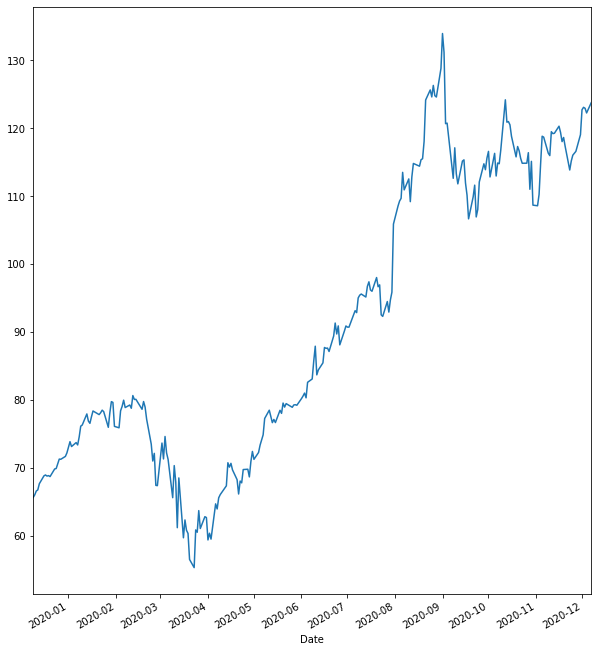

In [17]:
adj_close_data.plot(figsize=(10, 12), subplots=True)

In [19]:
std_deviation = np.log(adj_close_data / adj_close_data.shift(1)).std()
annualised_vol = np.sqrt(252) * std_deviation
print('The annualised volatility is', round(annualised_vol*100,2), '%')

The annualised volatility is 46.39 %


## Methodologies

###  Binomial Tree Model

In [85]:
spot_price = round(adj_close_data[-1], 2)             # spot stock price
strike_price = 110.0               # strike
time_maturity = 1.0                 # one year maturity 
rf_rate = 0.0094                 # annualised risk free rate 
time_steps = 3                   # number of periods or number of time steps  

In [86]:
up_factor = np.exp(annualised_vol * np.sqrt(float(time_maturity) / time_steps))     
down_factor = 1.0 / up_factor
print(up_factor, down_factor)

prices = np.zeros((time_steps + 1, time_steps + 1))
prices[0, 0] = spot_price
index = 1
for time in range(1, time_steps + 1):
    for i in range(index):
        prices[i, time] = prices[i, time-1] * up_factor
        prices[i+1, time] = prices[i, time-1] * down_factor
    index += 1

1.3071330474408762 0.7650330637403854


In [87]:
exponent = rf_rate * (float(time_maturity) / time_steps)    # risk free compound return
up_prob = (np.exp(exponent) - down_factor)/ (up_factor - down_factor)  # risk neutral up probability
down_prob = 1.0 - up_prob  
print(up_prob, down_prob)

expiry_prices = prices[:,-1]

valuation = np.zeros((time_steps + 1, time_steps + 1))
valuation[:,-1] = np.maximum(expiry_prices-strike_price, 0.0)

for column in range(time_steps-1, -1, -1):
    for index in range(column+1):
        valuation[index, column] = np.exp(-exponent) * (up_prob * valuation[index,column + 1] + 
                                                        down_prob * valuation[index + 1,column + 1])

print('Apple call option ', str(valuation[0,0]))

0.4392274317876937 0.5607725682123064
Apple call option  30.607385907928666


### Black-Scholes Model

In [88]:
d1 = (np.log(spot_price / strike_price) + 
      (rf_rate + 0.5 * annualised_vol ** 2) * time_maturity) / (annualised_vol * np.sqrt(time_maturity))
d2 = (np.log(spot_price / strike_price) + 
      (rf_rate - 0.5 * annualised_vol ** 2) * time_maturity) / (annualised_vol * np.sqrt(time_maturity))

option_value = spot_price * si.norm.cdf(d1, 0.0, 1.0) - strike_price * np.exp(-rf_rate * time_maturity) * si.norm.cdf(d2, 0.0, 1.0)

print('Apple call option ', str(option_value))

Apple call option  29.51465503876794


## Greeks

### Gamma

In [89]:
def gamma(d1,rf_rate, time_maturity, annualised_vol, spot_price):

    gamma = np.exp(-rf_rate * time_maturity) * si.norm.pdf(d1, 0.0, 1.0) / (annualised_vol * spot_price * time_maturity)
    
    return gamma

gamma(d1, rf_rate, time_maturity, annualised_vol, spot_price)

0.006056627706680449

### Delta

In [90]:
#without dividends q is 0.
def delta(d1):
    delta = si.norm.cdf(d1, 0.0, 1.0)
    return delta

delta(d1)

0.6936102546871415

### Speed

In [56]:
def speed(spot_price, time_maturity, annualised_vol):
    
    speed = si.norm.pdf(d1, 0.0, 1.0) / ((annualised_vol **2) * (spot_price**2) * time_maturity) * (d1 + annualised_vol * np.sqrt(time_maturity))
    
    return speed

speed(spot_price, time_maturity, annualised_vol)

0.00010502207961088425

### Theta

In [57]:
def theta(spot_price, strike_price, time_maturity, rf_rate, annualised_vol, d1, d2):
    
    theta = annualised_vol * spot_price * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(time_maturity)) + rf_rate * strike_price * np.exp(-rf_rate * time_maturity) * si.norm.cdf(d2, 0.0, 1.0)
    
    return theta

theta(spot_price, strike_price, time_maturity, rf_rate, annualised_vol, d1, d2)

11.321234812958991

### Rho

In [58]:
def rho(strike_price, time_maturity, rf_rate, d2):
    rho =  strike_price * time_maturity * np.exp(-rf_rate * time_maturity) * si.norm.cdf(d2, 0.0, 1.0)
    
    return rho

rho(strike_price, time_maturity, rf_rate, d2)

56.884536269627944

### Vega

In [91]:
def vega(spot_price, time_maturity, d1):
    
    vega = spot_price * np.sqrt(time_maturity) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

vega(spot_price, time_maturity, d1)

43.43437791018858